In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.layers import (
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    Input,
    MaxPool2D,
    Activation,
    Concatenate
)
from keras.models import Model


print(tf.__version__)
print(f'TensorFlow built with cuda? {tf.test.is_built_with_cuda()}')
print(f'TensorFlow built with GPU support? {tf.test.is_built_with_gpu_support()}')

2024-07-17 17:47:01.369247: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-17 17:47:01.397560: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 17:47:01.397595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 17:47:01.398681: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-17 17:47:01.403119: I tensorflow/core/platform/cpu_feature_gua

2.16.2
TensorFlow built with cuda? True
TensorFlow built with GPU support? True


In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpus

2024-07-17 17:47:03.077380: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-17 17:47:03.104541: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-17 17:47:03.104732: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
base_dir = './images/overlap'

images_dir ='./images/overlap/tiles'
masks_dir = './images/overlap/masks'

images_listdir = [img for img in os.listdir(images_dir) if img.endswith('jpg')]
masks_listdir = [img for img in os.listdir(masks_dir) if img.endswith('jpg')]

print(len(images_listdir))
print(len(masks_listdir))

521
521


In [4]:
random_images = np.random.choice(images_listdir, size = 9, replace = False)

In [5]:
IMG_SIZE = 512

def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

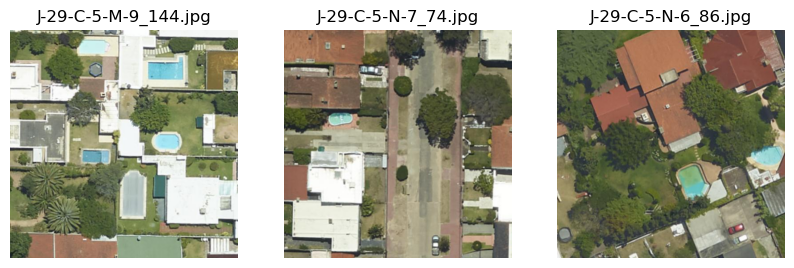

In [6]:
rows = 1
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10, 10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        input_path = f"{images_dir}/{random_images[i]}"
        img = read_image(input_path)
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

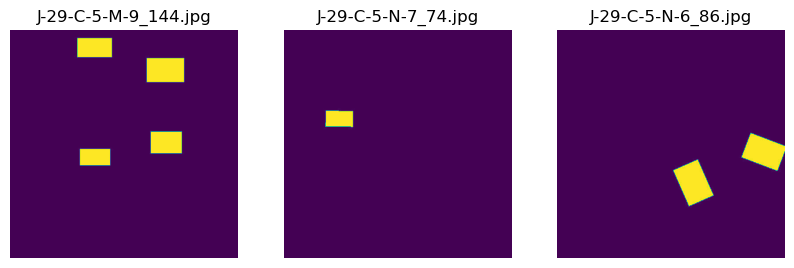

In [7]:
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i]
        if os.path.exists(os.path.join(masks_dir,file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

In [8]:
MASKS = np.zeros((1, IMG_SIZE, IMG_SIZE, 1), dtype=bool)
IMAGES = np.zeros((1, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for img_file, mask_file in zip(images_listdir, masks_listdir):
    fpath = f'images/overlap/tiles/{img_file}'
    image = read_image(fpath)
    image_ex = np.expand_dims(image, axis=0)
    image_normalized = tf.cast(image_ex, tf.float32) / 255.
    IMAGES = np.vstack([IMAGES, image_normalized])

    fpath = f'images/overlap/masks/{mask_file}'
    mask = read_image(fpath)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = mask.reshape(IMG_SIZE, IMG_SIZE, 1)
    mask_ex = np.expand_dims(mask, axis=0)
    mask_normalized = tf.cast(mask_ex, tf.float32) / 255.
    MASKS = np.vstack([MASKS, mask_normalized])

2024-07-17 17:47:04.508219: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-17 17:47:04.508478: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-17 17:47:04.508604: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [9]:
images = np.array(IMAGES)
masks = np.array(MASKS)

TRAIN_RATIO = 0.70
VALIDATION_RATIO = 0.2
TEST_RATIO = 0.1

X_train, X_temp, y_train, y_temp = train_test_split(
    images, masks, test_size=(1-TRAIN_RATIO), random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(TEST_RATIO/(TEST_RATIO + VALIDATION_RATIO)), random_state=42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(365, 512, 512, 3) (365, 512, 512, 1)
(104, 512, 512, 3) (104, 512, 512, 1)
(53, 512, 512, 3) (53, 512, 512, 1)


In [10]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2,2))(x)
    return x, p


def decoder_block(input, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape):
    inputs = Input(input_shape)

    'Encoder block'
    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    'Bridge'
    bridge = conv_block(pool4, 1024)

    'Decoder block'
    d1 = decoder_block(bridge, skip4, 512)
    d2 = decoder_block(d1, skip3, 256)
    d3 = decoder_block(d2, skip2, 128)
    d4 = decoder_block(d3, skip1, 64)

    'Output'
    outputs = Conv2D(1, (1,1), padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="U-Net")

    return model

In [11]:
unet_model = build_unet((IMG_SIZE, IMG_SIZE, 3))

metrics = ['acc']

unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_4[0][0]  

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [13]:
history = unet_model.fit(
    X_train, y_train,
    validation_data = [X_val, y_val],
    batch_size = 1,
    epochs = 20
    )

2024-07-17 17:49:37.769909: W external/local_tsl/tsl/framework/bfc_allocator.cc:487] Allocator (GPU_0_bfc) ran out of memory trying to allocate 365.00MiB (rounded to 382730240)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-07-17 17:49:37.770038: I external/local_tsl/tsl/framework/bfc_allocator.cc:1044] BFCAllocator dump for GPU_0_bfc
2024-07-17 17:49:37.770066: I external/local_tsl/tsl/framework/bfc_allocator.cc:1051] Bin (256): 	Total Chunks: 46, Chunks in use: 44. 11.5KiB allocated for chunks. 11.0KiB in use in bin. 692B client-requested in use in bin.
2024-07-17 17:49:37.770086: I external/local_tsl/tsl/framework/bfc_allocator.cc:1051] Bin (512): 	Total Chunks: 1, Chunks in use: 1. 512B allocated for chunks. 512B in use in bin. 512B client-requested in use in bin.
2024-07-17 17:49:37.770107: I 

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
history.save('./modelos/unet_512_20epochs_gpu_v2.keras')

In [ ]:
train_loss = unet_result.history['loss']
val_loss   = unet_result.history['val_loss']
train_acc  = unet_result.history['acc']
val_acc    = unet_result.history['val_acc']
xc         = range(20)

plt.figure()
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)